In [1]:
import xskillscore as xscore
import xarray as xr
import numpy as np
import xcdat as xc
import matplotlib as mpl

import os

from typing import Tuple
from matplotlib.colors import LinearSegmentedColormap

In [2]:
cdict2 = [
    (36,   0, 216),
    (24,  28, 247),
    (40,  87, 255),
    (61, 135, 255),
    (86, 176, 255),
    (117, 211, 255),
    (153, 234, 255),
    (188, 249, 255),
    (234, 255, 255),
    (255, 255, 234),
    (255, 241, 188),
    (255, 214, 153),
    (255, 172, 117),
    (255, 120,  86),
    (255,  61,  61),
    (247,  39,  53),
    (216,  21,  47),
    (165,   0,  33),
]
# Convert to 0 to 1
cdict2 = [(r/255, g/255, b/255) for i, (r, g, b) in enumerate(cdict2)]
mpl.colormaps.register(LinearSegmentedColormap.from_list('BWYR', cdict2))

In [11]:
# def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
#     shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
#     return ds1.sel(model=shared_models), ds2.sel(model=shared_models)

# # swcf_cmip6 = xr.open_dataset('data/piControl/swcf_cmip6_monthly_1850-2000.nc')
# swcf_cmip6 = xr.open_dataset('data/piControl/net-surface-cmip6_monthly_1850-2000.nc')
# # swcf_cmip6 = xr.open_dataset('data/piControl/lwcf-surface-cmip6_monthly_1850-2000.nc')
# print(swcf_cmip6)
# # ept = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc")
# ept = xr.open_dataarray("data/piControl/swcf_east_sa_cmip6_v3.nc")
# print(ept)

# swcf_cmip6, ept = get_shared_models(swcf_cmip6, ept)
# swcf_cmip6
def make_cyclic(ds):
    ds_end = ds.isel(lon=-1)
    ds_end["lon"] = 180
    ds_beg = ds.isel(lon=0)
    ds_beg["lon"] = -180
    ds_beg
    ds = xr.concat([ds_beg, ds, ds_end], dim="lon")
    return ds


def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)

swcf_cmip6_r2 = xr.open_dataset('data/piControl/swcf_cmip6_monthly_1850-2000.nc')
swcf_cmip5_r2 = xr.open_dataset('data/piControl/swcf_cmip5_monthly_1850-2000.nc')

swcf_cmip_r2 = xr.concat([swcf_cmip6_r2, swcf_cmip5_r2], dim="model")["swcf"]
# swcf_standard_std = np.fabs(swcf_cmip_r2.mean("model")) # swcf_cmip_r2.std("model") /
swcf_standard_std = np.fabs(swcf_cmip_r2.mean("model")) / swcf_cmip_r2.std("model") 

In [8]:
# r = xscore.pearson_r(swcf_cmip6["swcf"], ept.std('time'), dim='model', skipna=True)
r = xscore.pearson_r(swcf_cmip6["swcf"], ept, dim='model', skipna=True)
# r = swcf_cmip6["swcf"].std("model")
r

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


<xarray.DataArray 'swcf' (lat: 72, lon: 144)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.21361094, -0.2158692 , -0.21520673, ..., -0.1918098 ,
        -0.19355558, -0.2062134 ],
       [-0.20410329, -0.2018914 , -0.19786737, ..., -0.19877351,
        -0.20003931, -0.20303906],
       [-0.10612543, -0.10565993, -0.1050904 , ..., -0.10611395,
        -0.10634844, -0.10673418]])
Coordinates:
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8

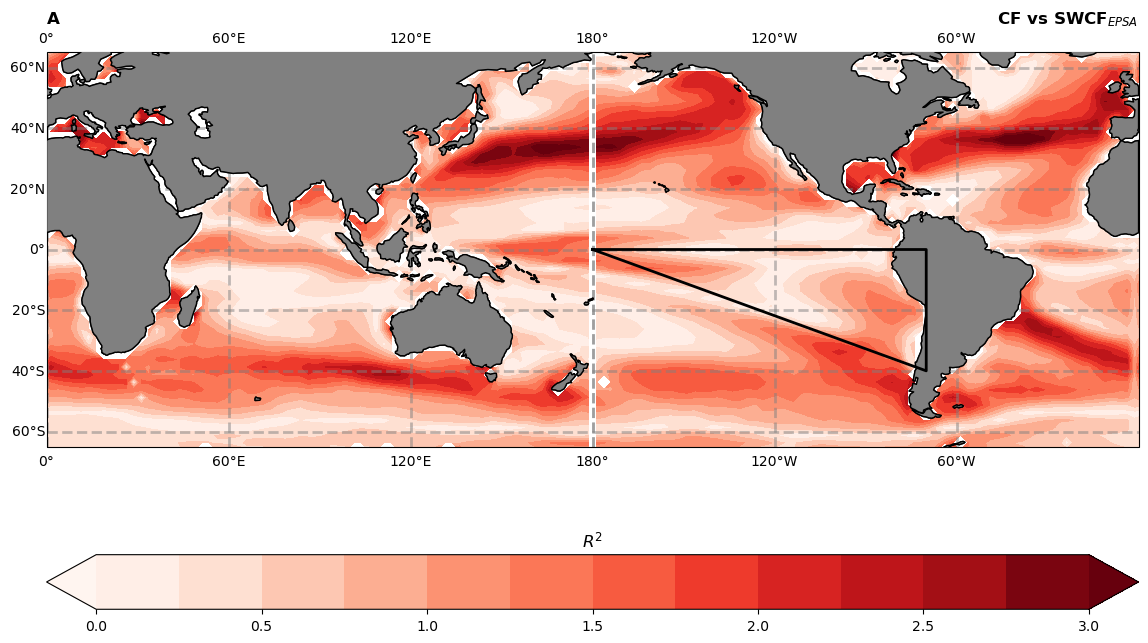

In [13]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

def _global_plot(ax, data, lon, lat, cmap, right_title="", left_title="", levels=np.arange(-4, 4.1, .1), cbar_label: str = ""):
    # plot map of global data with central longitude 180
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -65, 65
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    return img

def regression_maps(ds, info):
    fig = plt.figure(figsize=(12,12))
    gs = GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, hspace=.25, wspace=0.15)

    levels = info["levels"]
    # cmap = "BWYR"
    cmap = "Reds"

    img = _global_plot(
        ax1,
        data=ds,
        lat=ds.lat,
        lon=ds.lon,
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )
    title_fontsize = 12
    ax1.set_title(info["right_title_1"], loc="right", fontweight="bold", fontsize=title_fontsize)
    ax1.set_title(info["left_title_1"], loc="left", fontweight="bold", fontsize=title_fontsize)

    cbar = fig.colorbar(img, ax=ax1, orientation='horizontal', fraction=.1, pad=0.1)
    cbar.ax.set_title(info["cbar_label"], fontsize=12, fontweight="bold")

    save_name = info["save_name"]
    plt.savefig(os.path.join("figures", f"{save_name}.png"), dpi=400, bbox_inches='tight')

info = {
    "save_name": "r2_swcf_ept", 
    # "right_title_1": r"Net CF vs $\sigma[SST_{EPT}]$",
    "right_title_1": r"CF vs SWCF$_{EPSA}$",
    "left_title_1": "A",
    "cbar_label": r"$R^2$",
    "levels": np.arange(0, 3.25, .25), 
}

regression_maps(
    # ds=r**2,
    ds=swcf_standard_std,
    info=info
)